In [5]:
# LOADING REQUIRED LIBRARIES
# Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

# %#matplotlib inline

# Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Importing train, test split library
from sklearn.model_selection import train_test_split

# Metrices import
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

# Accuracy Check
from sklearn.model_selection import cross_val_score

# Importing custom packages
from sklearn.base import TransformerMixin

# Importing ML Model packages
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

# For proper display of all columns
from IPython.display import display

pd.options.display.max_columns = None

# Import warnings
import warnings

warnings.filterwarnings("ignore")

import statsmodels.api as sm

# Libraries for Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os

#importing relevant packages related to Fair ML/AI
import aif360
import holisticai
from aif360.datasets import BinaryLabelDataset
# holisticai imports
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.metrics import statistical_parity
from holisticai.bias.metrics import false_positive_rate_diff
from holisticai.bias.metrics import equal_opportunity_diff
from holisticai.bias.metrics import average_odds_diff
from holisticai.bias.metrics import disparate_impact

pip install 'aif360[LawSchoolGPA]'


In [8]:
# Read the data
data_raw = pd.read_csv("../../data/compas-scores-two-years.csv")

In [9]:
data_raw.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [10]:
def calculate_count_and_proportion_per_label(df, target_variable):
    """Calculates the count and proportion per label in a Pandas DataFrame with a binary target variable.

    Args:
      df: A Pandas DataFrame.
      target_variable: The name of the binary target variable in the DataFrame.

    Returns:
      A Pandas Series containing the count and proportion per label.
    """

    # Create a new Series containing the count per label.
    count_per_label = df[target_variable].value_counts()

    # Calculate the proportion per label.
    proportion_per_label = count_per_label / count_per_label.sum()

    # Return the Series containing the count and proportion per label.
    return pd.DataFrame(
        {
            "count_per_label": count_per_label,
            "proportion_per_label": proportion_per_label,
        }
    )

# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


def onehotdataframe(data, cat_cols):
    """
    Creates dummy features for categorical data.
    """
    for c in cat_cols:
        one_hot_col = pd.get_dummies(data[c])
        one_hot_col.columns = [str(col) + "_" + c for col in one_hot_col.columns]
        data = data.drop(c, axis=1)

        # Merging one hot encoded features with our dataset 'data'
        data = pd.concat([data, one_hot_col], axis=1)

    return data



# Calculate the count and proportion per label in the DataFrame.
df = calculate_count_and_proportion_per_label(data_raw, "two_year_recid")

# Print the count and proportion per label.
print(df)

   count_per_label  proportion_per_label
0             3963              0.549348
1             3251              0.450652


In [11]:
folder_path = "../../data"
file_path = os.path.join(folder_path, "data_baseline.csv")

data_baseline = pd.read_csv(file_path)

# Train Test Split

In [12]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_baseline.drop(['age_cat', 'two_year_recid'], axis = 1), data_baseline['two_year_recid'], test_size=0.2, random_state=1000, stratify = data_baseline['two_year_recid'])
#y_train.reset_index(drop = True, inplace = True)
#y_test.reset_index(drop = True, inplace = True)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the training data using the scaler
X_train_scaled = scaler.fit_transform(X_train.drop(['id'], axis = 1))
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.drop(['id'], axis = 1).columns, index = X_train.index)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test.drop(['id'], axis = 1))
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.drop(['id'], axis = 1).columns, index = X_test.index)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5748, 25), (1437, 25), (5748,), (1437,))

In [14]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((5748, 24), (1437, 24), (5748,), (1437,))

In [15]:
y_train.head()

5355    1
3592    0
29      1
2414    1
5619    1
Name: two_year_recid, dtype: int64

In [16]:
# check type of y_train
type(y_train)

pandas.core.series.Series

In [17]:
y_test.head()

3600    0
4218    0
900     0
5345    1
5682    0
Name: two_year_recid, dtype: int64

In [19]:
# Convert Pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [20]:
# Set the random seed for reproducibility
torch.manual_seed(10000)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,hidden_size3,output_size):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
hidden_size1 = 8
hidden_size2 = 8
hidden_size3 = 4
output_size = 1

model = MLPModel(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training the model
epochs = 50


for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    y_pred_prob = model(X_test_tensor)
    y_pred_test = (y_pred_prob >= 0.5).float()
    accuracy = (y_pred_test == y_test_tensor).float().mean()

print(f'Test Accuracy: {accuracy.item():.7f}')

Test Accuracy: 0.7000696


Classification Report for Artificial Neural Network model on test set

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       790
           1       0.68      0.64      0.66       647

    accuracy                           0.70      1437
   macro avg       0.70      0.69      0.70      1437
weighted avg       0.70      0.70      0.70      1437


 accuracy: 0.7000695894224078 & F1_Score: 0.6955019019239496 



<AxesSubplot:>

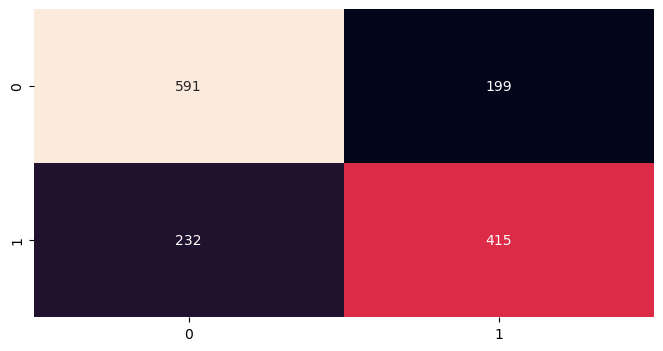

In [21]:
model_name = 'Artificial Neural Network'
print(
    "Classification Report for {} model on test set\n".format(model_name)
)
print(classification_report(y_test, y_pred_test))
print(
    "\n accuracy: {} & F1_Score: {} \n".format(
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average="macro"),
    )
)
cm_val = confusion_matrix(y_test, y_pred_test)

plt.subplots(figsize=(8, 4))
sns.heatmap(cm_val, annot=True, fmt="d", cbar=False)

In [52]:
# Dumping model
folder_path = "../../model"
file_path = os.path.join(folder_path, "mlp_model.pth")
torch.save(model.state_dict(), file_path)

In [22]:
# Convert to numpy
y_pred_prob = y_pred_prob.numpy().reshape(-1)
y_pred_test = y_pred_test.numpy().reshape(-1)

# Get a prediction df
predictions_df = pd.DataFrame(
    {
        "y_pred_prob": y_pred_prob,
        "y_pred_labels": y_pred_test,
        "y_true_labels": y_test.values,
    },
    index=X_test_scaled.index,
)

# Get the prediction in our test data
X_test["model_prediction"] = predictions_df["y_pred_labels"]
X_test["true_prediction"] = y_test

True Recidivism for African American

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

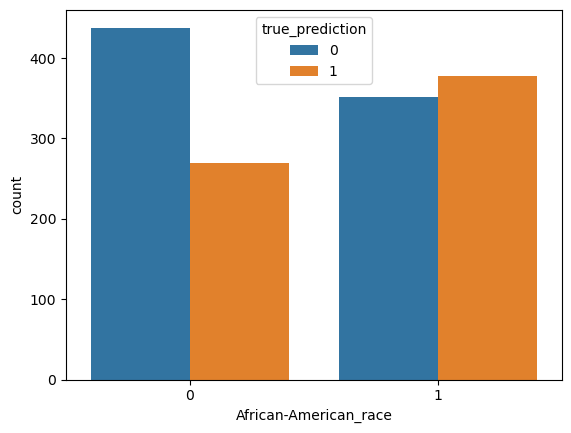

In [23]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'true_prediction')

Model Prediction for African Amerian

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

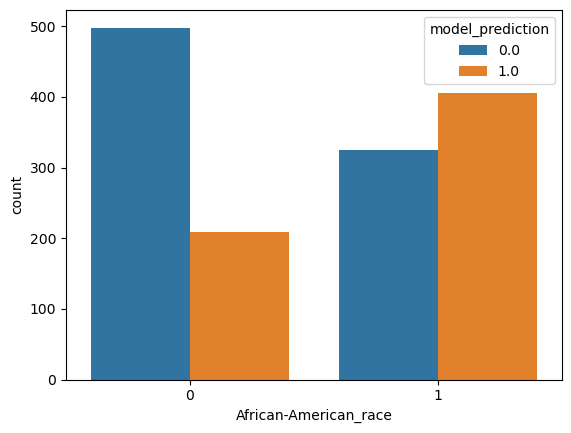

In [24]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

**Note:** We can observe clear bias towards this race

<AxesSubplot:xlabel='Other_race', ylabel='count'>

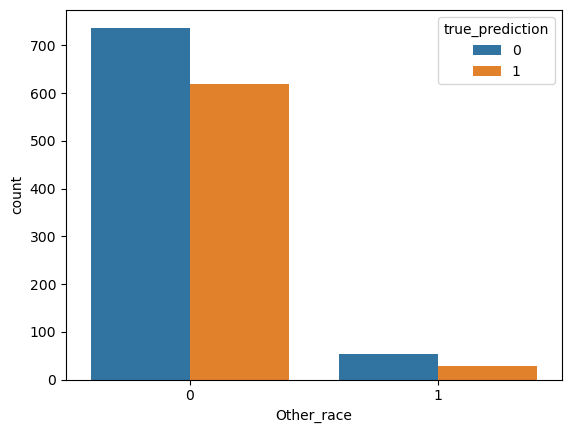

In [25]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'true_prediction')

<AxesSubplot:xlabel='Other_race', ylabel='count'>

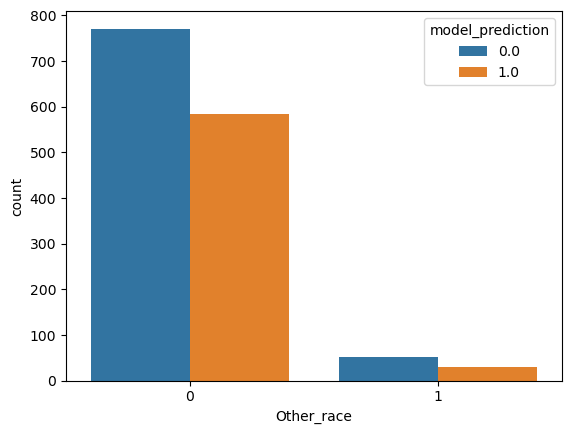

In [26]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'model_prediction')

This is balanced

<H1>FAIRNESS</H1> 

<h2>Evaluating fairness of the baseline model</h2>

In our case, sensitive attributes are gender and race. Therefore analysing the fairness metrics for these groups on below metrics:

<h3> We will check bias of baseline model against two sensitve variables sex and race.</h3>

<AxesSubplot:xlabel='sex', ylabel='count'>

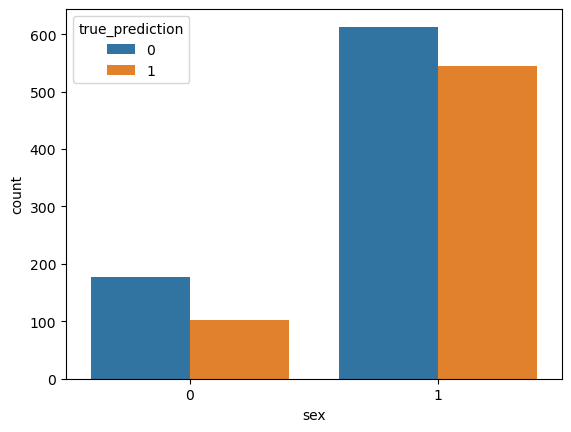

In [27]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'true_prediction')

<AxesSubplot:xlabel='sex', ylabel='count'>

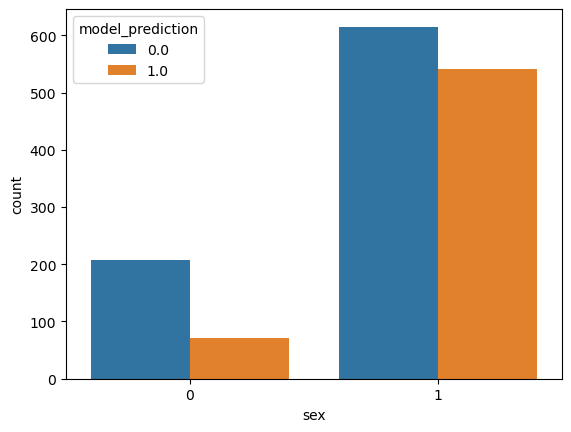

In [28]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'model_prediction')

Note: Evident bias against gender male

* checking probability distribution across genders

<Figure size 1000x600 with 0 Axes>

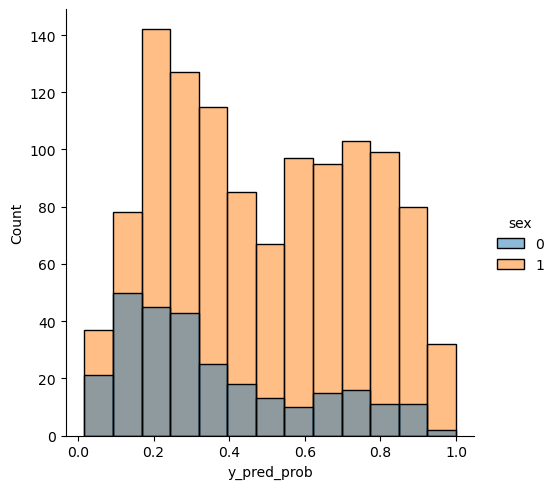

In [29]:
sex_prob_dist_df= pd.merge(predictions_df,X_test['sex'],left_index=True, right_index=True)
plt.figure(figsize=(10,6))
sns.displot(sex_prob_dist_df, x= 'y_pred_prob', hue='sex')

Checking the performance of the baseline model on the below metrics:
1. Statistical Parity : Comparing the Positive Prediction Rate/Precision across groups. i.e. comparing the actual postives against the predicted postives. i.e out of model's postive predictions, how many actually reoffended. A fair model should not have too low of a PPR for sensitive groups since that indicates that model unfairly predicts that many people would reoffend, compred to what aftually did
2. Equal Opportunity : What is the probability that an actual poitive will test positive, i.e. an actual reoffender will be classified as a reoffender? We will compare TPR across groups to compare this. Model should not have too low of a TPR for previledged groups
3. <b>False Positive Rate Disparity : difference across groups in the probability of falsely predicting the reoffence, when they didnt commit one. This will be the metric we will be trying to control going forward, to avoid falsly accusing innocents, and be fair across groups</b> 

<I>Note that the negative values of these metrics are due tot he fact that the metrics are defined considering '1' as 'favorable' outcome and '0' as unfavorable outcome, hence we will be taking negative signs of those and inverting the ratio metrics to keep the results intuitive and inline with thier usual meanings

In [30]:
gender_group_female = X_test['sex'] == 0
gender_group_male = X_test['sex'] == 1

<b>1. Statistical parity:</b>

In [31]:
abs(statistical_parity(gender_group_female,gender_group_male,y_pred_test))

0.21131003827633044

Statistical parity is positive. Meaning the model is biased against gender_group_male. It should be as close to 0 as possible.
We will try to verify it below

In [32]:
positive_pred_sex_df = X_test[X_test['model_prediction'] == 1] #taking positive predictions
Positive_pred_rate_sex_df = positive_pred_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
Positive_pred_rate_sex_df['PPR'] = Positive_pred_rate_sex_df['true_prediction']/Positive_pred_rate_sex_df['positive_prediction']
Positive_pred_rate_sex_df

,positive_prediction,true_prediction,PPR
sex,,,
0,72.0,47,0.652778
1,542.0,368,0.678967


very slight bias in terms of disriminating over gender as per statistical Parity

<b> 2. Equal opportunity : is there differene in Recall across gender groups? That means, out of all the true reoffenders across groups, are we eually likely to predict the chances of reoffence for all the groups? </b>


If we are fair, metric would be 0 , meaning equally likely to predict positive from actual positives across groups. more the deviation, more unfair we are

In [33]:
abs(equal_opportunity_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.22015990862364365

Model is slightly unfair towards male group. Let us verify by calculating recall across gender groups

In [34]:
positive_act_sex_df = X_test[X_test['true_prediction'] == 1] #taking positive actuals
true_pos_rate_sex_df = positive_act_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
true_pos_rate_sex_df['TPR'] = true_pos_rate_sex_df['positive_prediction']/true_pos_rate_sex_df['true_prediction']
true_pos_rate_sex_df

,positive_prediction,true_prediction,TPR
sex,,,
0,47.0,103,0.456311
1,368.0,544,0.676471


In [35]:
#MLP 

positive_act_sex_df = X_test[X_test['true_prediction'] == 1] #taking positive actuals
true_pos_rate_sex_df = positive_act_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
true_pos_rate_sex_df['TPR'] = true_pos_rate_sex_df['positive_prediction']/true_pos_rate_sex_df['true_prediction']
true_pos_rate_sex_df

,positive_prediction,true_prediction,TPR
sex,,,
0,47.0,103,0.456311
1,368.0,544,0.676471


Recall for Males is much much higher than Females, ideally it should be equal.

<b>3. False Positive Rate Disparity : Compares FPR, i.e probability of predicting as criminal even when they are not!

In [36]:
abs(false_positive_rate_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.14260698058082413

In [37]:
negative_act_sex_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_sex_df = negative_act_sex_df.groupby('sex')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_sex_df['FPR'] = fpr_sex_df['positive_prediction']/fpr_sex_df['actual_negatives']
fpr_sex_df

,positive_prediction,actual_negatives,FPR
sex,,,
0,25.0,177,0.141243
1,174.0,613,0.283850


In [38]:
# MLP
negative_act_sex_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_sex_df = negative_act_sex_df.groupby('sex')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_sex_df['FPR'] = fpr_sex_df['positive_prediction']/fpr_sex_df['actual_negatives']
fpr_sex_df

,positive_prediction,actual_negatives,FPR
sex,,,
0,25.0,177,0.141243
1,174.0,613,0.283850


[Text(0, 0, '0.141243'), Text(0, 0, '0.28385')]

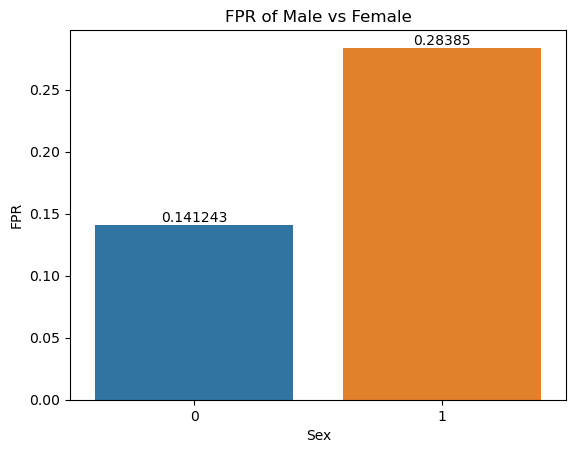

In [39]:
plt.figure()
ax = sns.barplot(x = fpr_sex_df.index, y = fpr_sex_df['FPR'])
plt.title("FPR of Male vs Female")
plt.xlabel("Sex")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

Males are more likely to be predicted as reoffenders even when they are not. 

<h3> doing similar analysis for race </h3>

In [40]:
X_test.columns

Index(['Unnamed: 0', 'id', 'sex', 'age', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_desc',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Asian_race', 'Caucasian_race',
       'Hispanic_race', 'Native American_race', 'Other_race',
       'Felony_c_charge_degree', 'Misdemeanor_c_charge_degree',
       'High_score_text', 'Low_score_text', 'Medium_score_text',
       'High_v_score_text', 'Low_v_score_text', 'Medium_v_score_text',
       'model_prediction', 'true_prediction'],
      dtype='object')

In [41]:
race_df = pd.merge(X_test[['sex','African-American_race','Asian_race','Caucasian_race','Hispanic_race', 'Native American_race', 'Other_race']],predictions_df,left_index=True,right_index=True)
race_df['sex'] =  race_df['sex'].astype("category")
race_df['African-American_race'] =  race_df['African-American_race'].astype("category")
race_df['Asian_race'] = race_df['Asian_race'].astype("category")
race_df['Caucasian_race'] = race_df['Caucasian_race'].astype("category")
race_df['Hispanic_race'] =  race_df['Hispanic_race'].astype("category")
race_df['Native American_race'] =  race_df['Native American_race'].astype("category")
race_df['Other_race'] =  race_df['Other_race'].astype("category")

In [42]:
fairness_eval_race_df = pd.DataFrame(columns=['column','fprd'])


In [43]:
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
for col in race_df.columns[0:7]:
	print(col)
	privileged_group = race_df[col] == 0
	unprivileged_group = race_df[col] == 1
	fpr_diff = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
	print(col, fpr_diff)

sex
sex 0.14260698058082413
African-American_race
African-American_race 0.17591583644665837
Asian_race
Asian_race -0.2541507024265645
Caucasian_race
Caucasian_race -0.15742264647794602
Hispanic_race
Hispanic_race -0.06335262505167422
Native American_race
Native American_race 0.2487309644670051
Other_race
Other_race 0.013133304318885819


In [44]:
privileged_group = race_df['African-American_race'] == 0
unprivileged_group = race_df['African-American_race'] == 1
print(equal_opportunity_diff(unprivileged_group,privileged_group,race_df['y_pred_labels'],race_df['y_true_labels']))

0.2516079542101847


<AxesSubplot:xlabel='African-American_race', ylabel='count'>

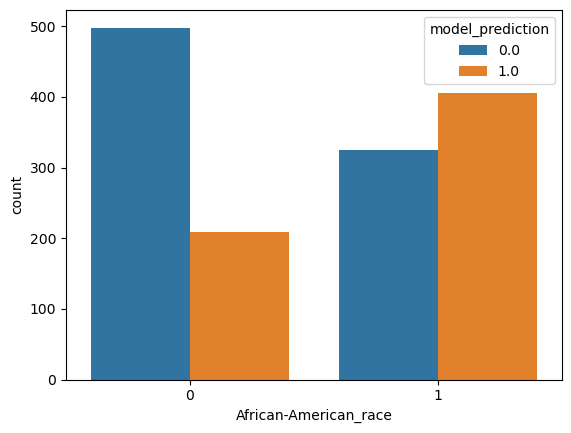

In [45]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

count of unprivileged vs previleged:
 False    1429
True        8
Name: Asian_race, dtype: int64
------------------------------------------------------------
statistical parity :  -0.3039713086074178
equal opportunity diff: 0.35913312693498456
fprd : -0.2541507024265645
dpi : 0.291394779771615



<Figure size 1000x600 with 0 Axes>

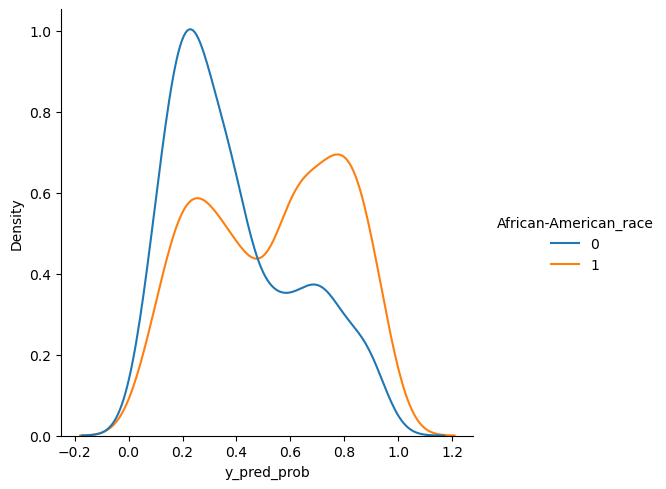

In [46]:
plt.figure(figsize=(10,6))
sns.displot(race_df, x= 'y_pred_prob', hue='African-American_race',kind='kde')
privileged_group = race_df['Asian_race'] == 0
unprivileged_group = race_df['Asian_race'] == 1
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
print("count of unprivileged vs previleged:\n",unprivileged_group.value_counts())
print("------------------------------------------------------------")
sp = statistical_parity(unprivileged_group,privileged_group,y_pred)
print("statistical parity : ", sp)
eod = equal_opportunity_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("equal opportunity diff:", eod)
fprd = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("fprd :",fprd )
dpi = disparate_impact(unprivileged_group,privileged_group,y_pred)
print("dpi :",dpi )

print()

In [47]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals

In [48]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_am_race_df = negative_act_amrace_df.groupby('African-American_race')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_am_race_df['FPR'] = fpr_am_race_df['positive_prediction']/fpr_am_race_df['actual_negatives']
fpr_am_race_df

,positive_prediction,actual_negatives,FPR
African-American_race,,,
0,76.0,438,0.173516
1,123.0,352,0.349432


[Text(0, 0, '0.173516'), Text(0, 0, '0.349432')]

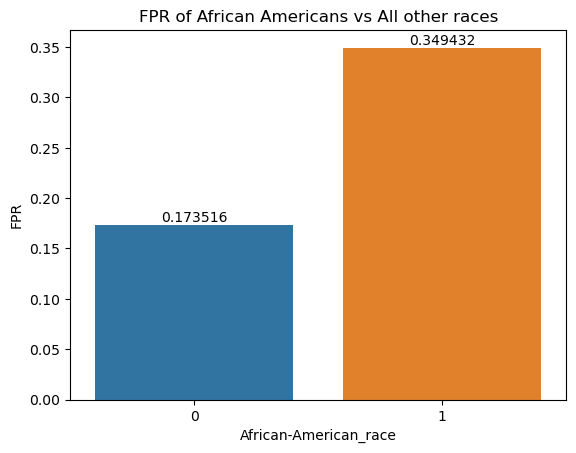

In [49]:
plt.figure()
ax = sns.barplot(x = fpr_am_race_df.index, y = fpr_am_race_df['FPR'])
plt.title("FPR of African Americans vs All other races")
plt.xlabel("African-American_race")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

African americans are 15% more likely to be wrongly accused of reoffense on an average

Remarks:
1. FPRs for both gender and African americans is significantly higher compared to previleged groups.
2. As we mititgate this bias, we should expect to see drop in model recall, since we are essentilly reducing the False Positives

<b><h2>  Mitigating the bias

<h4><b>1. In-Processing

- Modifying the data to reduce the bias in the model. 
1. Resampling :  We can resample the minority groups to make representation more fair, but in our case it is not advisable to generate aretififal samples due to the nature of the data and problem statement at hand
2. Reweighting : We will re-weight the data- minority samples in particular to increase their representation. 